In [2]:
# paquetes necesarios
import pandas as pd
import random
import copy

In [3]:
# lectura de archivos, Paridad.csv
pdf = pd.read_csv("Paridad.csv")
entradas = list(pdf[["A","B","C"]].itertuples(index=False, name=None))
salidas = pdf["S"].tolist()

In [4]:
# definición de los operadores lógicos 
class Booleanos:
    def __init__(self, operador, hijos=None):
        self.operador = operador
        self.hijos = hijos or []

    def eval(self, v):
        # terminal
        if not self.hijos:
            if self.operador in v:
                return v[self.operador]
            if self.operador in ("0", "1"):
                return int(self.operador)
            raise ValueError(f"Terminal desconocido: {self.operador}")
        # no terminal
        valores = [h.eval(v) for h in self.hijos]
        if self.operador == "AND":
            return valores[0] & valores[1]
        if self.operador == "OR":
            return valores[0] | valores[1]
        if self.operador == "NOT":
            return 1 - valores[0]
        if self.operador == "XOR":
            return valores[0] ^ valores[1]
        raise ValueError(f"Operador desconocido: {self.operador}")

    def lectura(self):
        # terminal
        if not self.hijos:
            return self.operador
        # NOT
        if self.operador == "NOT":
            return f"NOT({self.hijos[0].lectura()})"
        # AND, OR, XOR
        izq = self.hijos[0].lectura()
        der = self.hijos[1].lectura()
        return f"({izq} {self.operador} {der})"

In [5]:
# conjunto de funciones
F1 = [("AND",2), ("OR",2), ("NOT",1)]
F2 = [("AND",2), ("OR",2), ("NOT",1), ("XOR",2)]
# conjunto terminal
T = ["A", "B", "C", "0", "1"]

In [6]:
# definición de la estructura del árbol
def gen_arbol(max_p, funcs):
    def crecer(p):
        if p >= max_p or (p > 0 and random.random() < 0.3):
            return Booleanos(random.choice(T))
        n, aridad = random.choice(funcs)
        return Booleanos(n, [crecer(p+1) for _ in range(aridad)])
    return crecer(0)

In [7]:
# definición del conjunto de vértices hijos 
# de un descendencia(v), con v cualquier vértice
def descendencia(v):
    sal = [(None, None, v)]
    for idx, hijo in enumerate(v.hijos):
        for padre, i, nodo in descendencia(hijo):
            a = v if padre is None else padre
            b = idx if padre is None else i
            sal.append((a, b, nodo))
    return sal

In [8]:
# definición del punto de cruza 
def cruza(padre1, padre2):
    t1 = copy.deepcopy(padre1)
    t2 = copy.deepcopy(padre2)
    v1 = descendencia(t1)
    v2 = descendencia(t2)
    p1, i1, sub1 = random.choice(v1)
    p2, i2, sub2 = random.choice(v2)
    if p1 is None:
        hijo1 = sub2
    else:
        p1.hijos[i1] = sub2
        hijo1 = t1
    if p2 is None:
        hijo2 = sub1
    else:
        p2.hijos[i2] = sub1
        hijo2 = t2
    return hijo1, hijo2

In [9]:
# definición de mutación
def muta(arbol, funcs, max_p):
    t = copy.deepcopy(arbol)
    hojas = descendencia(t)
    padre, idx, _ = random.choice(hojas)
    nuevo = gen_arbol(max_p, funcs)
    if padre is None:
        return nuevo
    padre.hijos[idx] = nuevo
    return t

In [10]:
# definición de aptitud
def fit(ind, entradas, salidas):
    conta = 0
    for ent, sal in zip(entradas, salidas):
        v = {"A":ent[0], "B":ent[1], "C":ent[2]}
        if ind.eval(v) == sal:
            conta = conta + 1
    return conta

In [11]:
# parámetros
k = 3               # torneo
ngen = 100          # número de generaciones
pob_size = 100      # tamaño de la población
prob_cruza = 0.8    # probabilidad de cruza
prob_muta = 0.1     # probabilidad de mutación
max_p = 4           # máxima profundidad

In [12]:
# torneo de k individuos
def torneo(pob, k=3):
    aspirantes = random.sample(pob, k)
    return max(aspirantes, key=lambda ind: ind.fit)

In [13]:
# programación genética
def PG(funcs, ngen, pob_size, prob_cruza, prob_muta, max_p):
    pob = [gen_arbol(max_p, funcs) for _ in range(pob_size)]
    for ind in pob:
        ind.fit = fit(ind, entradas, salidas)
    top = max(pob, key=lambda ind: ind.fit)
    no_mejora = 0
    
    for gen in range(1, ngen+1):
        nueva = []
        while len(nueva) < pob_size:
            p1 = torneo(pob)
            p2 = torneo(pob)
            if random.random() < prob_cruza:
                c1, c2 = cruza(p1, p2)
            else:
                c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)
            if random.random() < prob_muta:
                c1 = muta(c1, funcs, max_p)
            if random.random() < prob_muta:
                c2 = muta(c2, funcs, max_p)
            c1.fit = fit(c1, entradas, salidas)
            c2.fit = fit(c2, entradas, salidas)
            nueva.extend([c1, c2])
        pob = nueva
        mejor = max(pob, key=lambda ind: ind.fit)
        print(f"Gen {gen:02d}: mejor fitness = {mejor.fit}/{len(entradas)}")
        
        # condición de paro
        if mejor.fit > top.fit:
            top, no_mejora = mejor, 0
        else:
            no_mejora = no_mejora + 1

        if mejor.fit == len(entradas):
            print(f"Aptitud alcanzada en {gen} generaciones")
            break

        if no_mejora >= 25:
            print(f"No mejora en {no_mejora} generaciones")
            break
    return mejor, mejor.fit / len(entradas)

In [22]:
if __name__ == "__main__":
    n_exps = 25
    f1_salida = []
    f2_salida = []

    print ("=====F1=====")
    for exps in range(1, n_exps + 1):
        print(f"--Experimento \n {exps}/{n_exps}--")
        best1, acc1 = PG(F1, ngen, pob_size, prob_cruza, prob_muta, max_p)
        f1_salida.append(acc1)
        print("Mejor ecuación:", best1.lectura())
        print(f" Exactitud: {acc1*100:.1f}%\n")

    print ("=====F2=====")
    for exps in range(1, n_exps + 1):
        print(f"--Experimento \n {exps}/{n_exps}--")
        best2, acc2 = PG(F2, ngen, pob_size, prob_cruza, prob_muta, max_p)
        f2_salida.append(acc2)
        print("Mejor ecuación:", best2.lectura())
        print(f" Exactitud: {acc2*100:.1f}%\n")

=====F1=====
--Experimento 
 1/25--
Gen 01: mejor fitness = 5/8
Gen 02: mejor fitness = 5/8
Gen 03: mejor fitness = 5/8
Gen 04: mejor fitness = 5/8
Gen 05: mejor fitness = 5/8
Gen 06: mejor fitness = 5/8
Gen 07: mejor fitness = 5/8
Gen 08: mejor fitness = 6/8
Gen 09: mejor fitness = 6/8
Gen 10: mejor fitness = 6/8
Gen 11: mejor fitness = 6/8
Gen 12: mejor fitness = 6/8
Gen 13: mejor fitness = 6/8
Gen 14: mejor fitness = 6/8
Gen 15: mejor fitness = 6/8
Gen 16: mejor fitness = 7/8
Gen 17: mejor fitness = 7/8
Gen 18: mejor fitness = 7/8
Gen 19: mejor fitness = 7/8
Gen 20: mejor fitness = 7/8
Gen 21: mejor fitness = 7/8
Gen 22: mejor fitness = 7/8
Gen 23: mejor fitness = 7/8
Gen 24: mejor fitness = 7/8
Gen 25: mejor fitness = 7/8
Gen 26: mejor fitness = 7/8
Gen 27: mejor fitness = 7/8
Gen 28: mejor fitness = 7/8
Gen 29: mejor fitness = 7/8
Gen 30: mejor fitness = 7/8
Gen 31: mejor fitness = 7/8
Gen 32: mejor fitness = 7/8
Gen 33: mejor fitness = 7/8
Gen 34: mejor fitness = 7/8
Gen 35: mejo

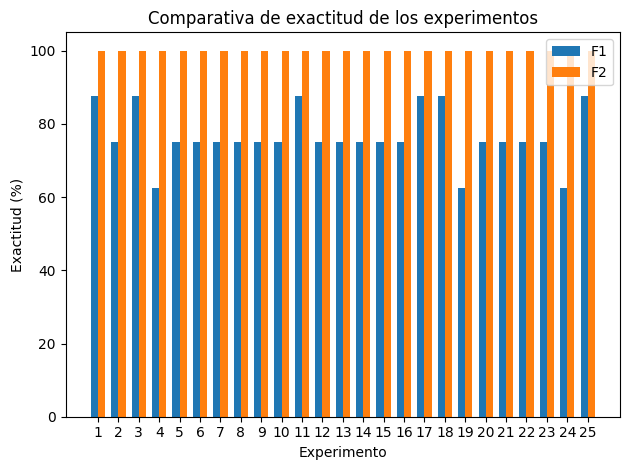

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
runs = np.arange(1, n_exps+1)
f1 = [x*100 for x in f1_salida]
f2 = [x*100 for x in f2_salida]


width = 0.35

plt.figure()

plt.bar(runs - width/2, f1, width, label='F1')

plt.bar(runs + width/2, f2, width, label='F2')

plt.xlabel('Experimento')
plt.ylabel('Exactitud (%)')
plt.title('Comparativa de exactitud de los experimentos')
plt.xticks(runs)        
plt.legend()
plt.tight_layout()
plt.show()